In [1]:
import numpy as np
import pandas as pd
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV
import lightgbm as lgb
import matplotlib.pyplot as plt

In [2]:
mvp_cluster = 3

### Data Retrieval

In [3]:
cus_data = pd.read_csv('./input/orders.csv', parse_dates= ['delivery_date', 'created_at' ]) #### Making sure that the dates columns are properly read
draft = pd.read_csv('./input/cluster_output.csv')

C:\Users\Anita Singh\AppData\Local\Temp\ipykernel_4148\1228978415.py:1: DtypeWarning: Columns (15,16,18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  cus_data = pd.read_csv('./input/orders.csv', parse_dates= ['delivery_date', 'created_at' ]) #### Making sure that the dates columns are properly read


In [4]:
allowedVendor = pd.DataFrame({'vendor_id':draft[draft.cluster==mvp_cluster].vendor_id.unique()})
allowedVendor.shape[0]

60

In [5]:
cus_data.columns

Index(['akeed_order_id', 'customer_id', 'item_count', 'grand_total',
       'payment_mode', 'promo_code', 'vendor_discount_amount',
       'promo_code_discount_percentage', 'is_favorite', 'is_rated',
       'vendor_rating', 'driver_rating', 'deliverydistance', 'preparationtime',
       'delivery_time', 'order_accepted_time', 'driver_accepted_time',
       'ready_for_pickup_time', 'picked_up_time', 'delivered_time',
       'delivery_date', 'vendor_id', 'created_at', 'LOCATION_NUMBER',
       'LOCATION_TYPE', 'CID X LOC_NUM X VENDOR'],
      dtype='object')

In [6]:
### Data Preprocessing

In [7]:
cus_data = cus_data.drop(['vendor_discount_amount','delivery_time','order_accepted_time','promo_code','driver_rating','driver_accepted_time','ready_for_pickup_time','picked_up_time','delivered_time','promo_code_discount_percentage','LOCATION_NUMBER','LOCATION_TYPE', 'CID X LOC_NUM X VENDOR'],axis=1)
cus_data.columns

Index(['akeed_order_id', 'customer_id', 'item_count', 'grand_total',
       'payment_mode', 'is_favorite', 'is_rated', 'vendor_rating',
       'deliverydistance', 'preparationtime', 'delivery_date', 'vendor_id',
       'created_at'],
      dtype='object')

In [8]:
cus_data.rename(columns = {'item_count':'head_count', 'deliverydistance':'vendor_distance', 'preparationtime':'waiting_time','delivery_date':'booked_date',}, inplace = True)

In [9]:
cus_data.drop(cus_data.index[cus_data.akeed_order_id.isnull()], inplace= True)
cus_data.drop(cus_data.index[cus_data.booked_date.isnull()], inplace= True)

In [10]:
### Let's also check if the booked_date is greater than the created_at ###
cus_data['booked_date'],cus_data['created_at'] = np.where(cus_data['booked_date'] >= cus_data['created_at'],(cus_data['booked_date'],cus_data['created_at']),(cus_data['created_at'],cus_data['booked_date'])) 

In [11]:
cus_data.head(3)

,akeed_order_id,customer_id,head_count,grand_total,payment_mode,is_favorite,is_rated,vendor_rating,vendor_distance,waiting_time,booked_date,vendor_id,created_at
0,163238.0,92PEE24,1.0,7.6,2,NaN,No,NaN,0.0,NaN,2019-08-01 05:30:16,105,2019-07-31 05:30:00
1,163240.0,QS68UD8,1.0,8.7,1,NaN,No,NaN,0.0,NaN,2019-08-01 05:31:10,294,2019-07-31 05:30:00
2,163241.0,MB7VY5F,2.0,14.4,1,NaN,No,NaN,0.0,NaN,2019-08-01 05:31:33,83,2019-07-31 05:30:00


In [12]:
cus_data.describe()

,akeed_order_id,head_count,grand_total,payment_mode,vendor_rating,vendor_distance,waiting_time,booked_date,vendor_id,created_at
count,35544.000000,35544.000000,35544.000000,35544.000000,439.000000,35544.0,0.0,35544,35544.000000,35544
mean,158791.371540,2.675163,16.851131,1.211259,4.373576,0.0,NaN,2019-07-25 19:02:42.530103808,136.517528,2019-07-25 00:22:53.735735808
min,124410.000000,1.000000,0.000000,1.000000,0.000000,0.0,NaN,2019-06-01 00:03:04,4.000000,2019-05-31 00:00:00
25%,140961.250000,1.000000,8.700000,1.000000,4.000000,0.0,NaN,2019-06-27 13:46:08.750000128,83.000000,2019-06-27 00:00:00
50%,157878.500000,2.000000,12.800000,1.000000,5.000000,0.0,NaN,2019-07-24 00:16:25.500000,113.000000,2019-07-23 05:30:00
75%,176093.250000,3.000000,20.400000,1.000000,5.000000,0.0,NaN,2019-08-23 05:15:07,193.000000,2019-08-22 05:30:00
max,196294.000000,47.000000,524.200000,5.000000,5.000000,0.0,NaN,2019-09-18 20:54:16,419.000000,2019-09-18 05:30:00
std,20601.785273,1.877231,13.791477,0.448472,1.115206,0.0,NaN,NaN,76.950637,NaN


In [13]:
### Replacing 'Nan' values in head_count in last 7 days and last 4 weeks with 0 ###
cus_data['head_count'][cus_data['head_count'].isnull()] = 1
cus_data['waiting_time'][cus_data['waiting_time'].isnull()] = 0
cus_data['vendor_rating'][cus_data['vendor_rating'].isnull()] = 0
cus_data['is_favorite'][cus_data['is_favorite'].isnull()] = 'No'

C:\Users\Anita Singh\AppData\Local\Temp\ipykernel_4148\1444089222.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cus_data['head_count'][cus_data['head_count'].isnull()] = 1
C:\Users\Anita Singh\AppData\Local\Temp\ipykernel_4148\1444089222.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cus_data['waiting_time'][cus_data['waiting_time'].isnull()] = 0
C:\Users\Anita Singh\AppData\Local\Temp\ipykernel_4148\1444089222.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing

In [14]:
### Validating the preprocessing ###
print('# of negatives in Avg Dist: '+ str(len(cus_data.vendor_distance[cus_data.vendor_distance < 0])))
print(cus_data.isnull().sum(axis = 0))

# of negatives in Avg Dist: 0
akeed_order_id     0
customer_id        0
head_count         0
grand_total        0
payment_mode       0
is_favorite        0
is_rated           0
vendor_rating      0
vendor_distance    0
waiting_time       0
booked_date        0
vendor_id          0
created_at         0
dtype: int64


In [15]:
print(draft.shape)

(35544, 10)


In [16]:
draft.customer_id.unique().shape[0]

11016

In [17]:
cus_data.vendor_id.unique().shape[0]   ### Reveals that none of the customers is repeated more than once

74

In [18]:
data = {
    'tra':
    pd.read_csv('./input/air_visit_data.csv'),
    'as':
    pd.read_csv('./input/air_store_info.csv'),
    'hs':
    pd.read_csv('./input/hpg_store_info.csv'),
    'ar':
    pd.read_csv('./input/air_reserve.csv'),
    'hr':
    pd.read_csv('./input/hpg_reserve.csv'),
    'id':
    pd.read_csv('./input/store_id_relation.csv'),
    'tes':
    pd.read_csv('./input/sample_submission.csv'),
    'hol':
    pd.read_csv('./input/date_info.csv').rename(columns={
        'calendar_date': 'visit_date'
    })
}
for x,y in data.items():
    display(y.head(1))

,air_store_id,visit_date,visitors
0,air_ba937bf13d40fb24,2016-01-13,25


,air_store_id,air_genre_name,air_area_name,latitude,longitude
0,air_0f0cdeee6c9bf3d7,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197853


,hpg_store_id,hpg_genre_name,hpg_area_name,latitude,longitude
0,hpg_6622b62385aec8bf,Japanese style,Tōkyō-to Setagaya-ku Taishidō,35.643675,139.668221


,air_store_id,visit_datetime,reserve_datetime,reserve_visitors
0,air_877f79706adbfb06,2016-01-01 19:00:00,2016-01-01 16:00:00,1


,hpg_store_id,visit_datetime,reserve_datetime,reserve_visitors
0,hpg_c63f6f42e088e50f,2016-01-01 11:00:00,2016-01-01 09:00:00,1


,air_store_id,hpg_store_id
0,air_63b13c56b7201bd9,hpg_4bc649e72e2a239a


,id,visitors
0,air_00a91d42b08b08d9_2017-04-23,0


,visit_date,day_of_week,holiday_flg
0,2016-01-01,Friday,1


### Data Creation and Culmination of Previously Generatred Data

In [19]:
data['id'].air_store_id.unique().shape[0]   ### Reveals that none of the customers is repeated more than once

150

In [20]:
data['id'].air_store_id.head()

0    air_63b13c56b7201bd9
1    air_a24bf50c3e90d583
2    air_c7f78b4f3cba33ff
3    air_947eb2cae4f3e8f2
4    air_965b2e0cf4119003
Name: air_store_id, dtype: object

In [21]:
airVen = pd.DataFrame({'air_store_id':data['id'].air_store_id.head(cus_data.vendor_id.unique().shape[0]), 'vendor_id':cus_data.vendor_id.unique()})
airVen

,air_store_id,vendor_id
0,air_63b13c56b7201bd9,105
1,air_a24bf50c3e90d583,294
2,air_c7f78b4f3cba33ff,83
3,air_947eb2cae4f3e8f2,90
4,air_965b2e0cf4119003,78
...,...,...
69,air_152c1f08d7d20e07,356
70,air_90213bcae4afa274,419
71,air_54d6c25d33f5260e,391
72,air_4c727b55acdee495,67


In [22]:
aVenMap = {}
vAenMap = {}
for i in range(airVen.shape[0]):
    aVenMap[airVen.iloc[i,0]] =airVen.iloc[i,1]
    vAenMap[airVen.iloc[i,1]] =airVen.iloc[i,0]

In [23]:
notInc = pd.DataFrame({'air_store_id': data['id'].air_store_id.unique()[cus_data.vendor_id.unique().shape[0]:]})
notInc

,air_store_id
0,air_42d41eb58cad170e
1,air_f0fb0975bdc2cdf9
2,air_97159fc4e90053fe
3,air_5a9a6cbeeb434c08
4,air_4570f52104fe0982
...,...
71,air_b8925441167c3152
72,air_f8233ad00755c35c
73,air_6607fe3671242ce3
74,air_ccd19a5bc5573ae5


In [24]:
for x,y in data.items():
    if ('air_store_id' in y.columns):
        print(y.shape[0])
        y = y.drop(y.index[ y.air_store_id.isin(airVen.air_store_id).ne(True)], inplace= False)
        data[x] = y
        print(y.shape[0])

252108
22600
829
74
92378
20218
150
74


In [25]:
for x,y in data.items():
    if ('air_store_id' in y.columns):
        for ix,iy in aVenMap.items():
            #y.air_store_id = np.where(y.air_store_id == ix,iy,y.air_store_id)
            y.loc[y["air_store_id"] == ix, 'air_store_id'] = iy
            data[x]= y

for x,y in data.items():
    display(y.head(1))

,air_store_id,visit_date,visitors
8330,148,2016-01-03,132


,air_store_id,air_genre_name,air_area_name,latitude,longitude
1,201,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197853


,hpg_store_id,hpg_genre_name,hpg_area_name,latitude,longitude
0,hpg_6622b62385aec8bf,Japanese style,Tōkyō-to Setagaya-ku Taishidō,35.643675,139.668221


,air_store_id,visit_datetime,reserve_datetime,reserve_visitors
1,271,2016-01-01 19:00:00,2016-01-01 19:00:00,3


,hpg_store_id,visit_datetime,reserve_datetime,reserve_visitors
0,hpg_c63f6f42e088e50f,2016-01-01 11:00:00,2016-01-01 09:00:00,1


,air_store_id,hpg_store_id
0,105,hpg_4bc649e72e2a239a


,id,visitors
0,air_00a91d42b08b08d9_2017-04-23,0


,visit_date,day_of_week,holiday_flg
0,2016-01-01,Friday,1


In [26]:
data['hr'] = pd.merge(data['hr'], data['id'], how='inner', on=['hpg_store_id'])

for df in ['ar', 'hr']:
    data[df]['visit_datetime'] = pd.to_datetime(data[df]['visit_datetime'])
    data[df]['visit_datetime'] = data[df]['visit_datetime'].dt.date
    data[df]['reserve_datetime'] = pd.to_datetime(data[df]['reserve_datetime'])
    data[df]['reserve_datetime'] = data[df]['reserve_datetime'].dt.date
    data[df]['reserve_datetime_diff'] = data[df].apply(
        lambda r: (r['visit_datetime'] - r['reserve_datetime']).days, axis=1)
    data[df] = data[df].groupby(
        ['air_store_id', 'visit_datetime'], as_index=False)[[
            'reserve_datetime_diff', 'reserve_visitors'
        ]].sum().rename(columns={
            'visit_datetime': 'visit_date'
        })
    display(data[df].head())

,air_store_id,visit_date,reserve_datetime_diff,reserve_visitors
0,4,2016-01-31,5,7
1,4,2016-06-13,4,2
2,4,2016-06-21,12,4
3,4,2017-01-25,10,2
4,4,2017-02-16,0,4


,air_store_id,visit_date,reserve_datetime_diff,reserve_visitors
0,4,2016-01-11,2,2
1,4,2016-02-05,1,2
2,4,2016-02-29,1,6
3,4,2016-03-21,3,10
4,4,2016-04-09,2,3


In [27]:
data['tra']['visit_date'] = pd.to_datetime(data['tra']['visit_date'])
data['tra']['dow'] = data['tra']['visit_date'].dt.dayofweek
data['tra']['year'] = data['tra']['visit_date'].dt.year
data['tra']['month'] = data['tra']['visit_date'].dt.month
data['tra']['visit_date'] = data['tra']['visit_date'].dt.date

data['tra'].head()

,air_store_id,visit_date,visitors,dow,year,month
8330,148,2016-01-03,132,6,2016,1
8331,148,2016-01-04,7,0,2016,1
8332,148,2016-01-08,4,4,2016,1
8333,148,2016-01-09,45,5,2016,1
8334,148,2016-01-10,2,6,2016,1


In [28]:
data['tes']['visit_date'] = data['tes']['id'].map(
    lambda x: str(x).split('_')[2])
data['tes']['air_store_id'] = data['tes']['id'].map(
    lambda x: '_'.join(x.split('_')[:2]))
data['tes']['visit_date'] = pd.to_datetime(data['tes']['visit_date'])
data['tes']['dow'] = data['tes']['visit_date'].dt.dayofweek
data['tes']['year'] = data['tes']['visit_date'].dt.year
data['tes']['month'] = data['tes']['visit_date'].dt.month
data['tes']['visit_date'] = data['tes']['visit_date'].dt.date

data['tes'].head()

,id,visitors,visit_date,air_store_id,dow,year,month
0,air_00a91d42b08b08d9_2017-04-23,0,2017-04-23,air_00a91d42b08b08d9,6,2017,4
1,air_00a91d42b08b08d9_2017-04-24,0,2017-04-24,air_00a91d42b08b08d9,0,2017,4
2,air_00a91d42b08b08d9_2017-04-25,0,2017-04-25,air_00a91d42b08b08d9,1,2017,4
3,air_00a91d42b08b08d9_2017-04-26,0,2017-04-26,air_00a91d42b08b08d9,2,2017,4
4,air_00a91d42b08b08d9_2017-04-27,0,2017-04-27,air_00a91d42b08b08d9,3,2017,4


In [29]:
y = data['tes']
x = 'tes'
if ('air_store_id' in y.columns):
        print(y.shape[0])
        y = y.drop(y.index[ y.air_store_id.isin(airVen.air_store_id).ne(True)], inplace= False)
        data[x] = y
        print(y.shape[0])
if ('air_store_id' in y.columns):
        for ix,iy in aVenMap.items():
            #y.air_store_id = np.where(y.air_store_id == ix,iy,y.air_store_id)
            y.loc[y["air_store_id"] == ix, 'air_store_id'] = iy
            data[x]= y


32019
2886


In [30]:
data['tes'].id = data['tes'].agg(lambda x: f"{x['air_store_id']}_{x['visit_date']}", axis=1)
display(y.head())

,id,visitors,visit_date,air_store_id,dow,year,month
0,85_2017-04-23,0,2017-04-23,85,6,2017,4
1,85_2017-04-24,0,2017-04-24,85,0,2017,4
2,85_2017-04-25,0,2017-04-25,85,1,2017,4
3,85_2017-04-26,0,2017-04-26,85,2,2017,4
4,85_2017-04-27,0,2017-04-27,85,3,2017,4


### Allowing Vendors included in Most Valuable Customer Clusters

In [31]:
for x,y in data.items():
    if ('air_store_id' in y.columns):
        print(y.shape[0])
        y = y.drop(y.index[ y.air_store_id.isin(allowedVendor.vendor_id).ne(True)], inplace= False)
        data[x] = y
        print(y.shape[0])

22600
18226
74
60
6314
5858
9675
8256
74
60
2886
2340


In [32]:
unique_stores = data['tes']['air_store_id'].unique()
stores = pd.concat(
    [
        pd.DataFrame({
            'air_store_id': unique_stores,
            'dow': [i] * len(unique_stores)
        }) for i in range(7)
    ],
    axis=0,
    ignore_index=True).reset_index(drop=True)

stores.head()

,air_store_id,dow
0,85,0
1,104,0
2,28,0
3,176,0
4,75,0


### Data Metric Creation

In [33]:
tmp = data['tra'].groupby(
    ['air_store_id', 'dow'],
    as_index=False)['visitors'].min().rename(columns={
        'visitors': 'min_visitors'
    })
stores = pd.merge(stores, tmp, how='left', on=['air_store_id', 'dow'])
tmp = data['tra'].groupby(
    ['air_store_id', 'dow'],
    as_index=False)['visitors'].mean().rename(columns={
        'visitors': 'mean_visitors'
    })
stores = pd.merge(stores, tmp, how='left', on=['air_store_id', 'dow'])
tmp = data['tra'].groupby(
    ['air_store_id', 'dow'],
    as_index=False)['visitors'].median().rename(columns={
        'visitors': 'median_visitors'
    })
stores = pd.merge(stores, tmp, how='left', on=['air_store_id', 'dow'])
tmp = data['tra'].groupby(
    ['air_store_id', 'dow'],
    as_index=False)['visitors'].max().rename(columns={
        'visitors': 'max_visitors'
    })
stores = pd.merge(stores, tmp, how='left', on=['air_store_id', 'dow'])
tmp = data['tra'].groupby(
    ['air_store_id', 'dow'],
    as_index=False)['visitors'].count().rename(columns={
        'visitors': 'count_observations'
    })
stores = pd.merge(stores, tmp, how='left', on=['air_store_id', 'dow'])
stores.head()

,air_store_id,dow,min_visitors,mean_visitors,median_visitors,max_visitors,count_observations
0,85,0,1.0,22.457143,19.0,47.0,35.0
1,104,0,2.0,14.487805,12.0,37.0,41.0
2,28,0,2.0,13.967742,12.0,62.0,31.0
3,176,0,3.0,11.806452,11.0,23.0,31.0
4,75,0,7.0,28.024390,26.0,49.0,41.0


### Model (Label Encoder) Preprocessing 

In [34]:
stores = pd.merge(stores, data['as'], how='left', on=['air_store_id'])
lbl = preprocessing.LabelEncoder()
stores['air_genre_name'] = lbl.fit_transform(stores['air_genre_name'])
stores['air_area_name'] = lbl.fit_transform(stores['air_area_name'])
stores.head()

,air_store_id,dow,min_visitors,mean_visitors,median_visitors,max_visitors,count_observations,air_genre_name,air_area_name,latitude,longitude
0,85,0,1.0,22.457143,19.0,47.0,35.0,4,14,35.694003,139.753595
1,104,0,2.0,14.487805,12.0,37.0,41.0,5,5,43.074470,141.300889
2,28,0,2.0,13.967742,12.0,62.0,31.0,4,3,34.386244,132.455018
3,176,0,3.0,11.806452,11.0,23.0,31.0,4,16,35.670651,139.771861
4,75,0,7.0,28.024390,26.0,49.0,41.0,8,6,43.055460,141.340956


In [35]:
data['hol']['visit_date'] = pd.to_datetime(data['hol']['visit_date'])
data['hol']['day_of_week'] = lbl.fit_transform(data['hol']['day_of_week'])
data['hol']['visit_date'] = data['hol']['visit_date'].dt.date
data['hol'].head()

,visit_date,day_of_week,holiday_flg
0,2016-01-01,0,1
1,2016-01-02,2,1
2,2016-01-03,3,1
3,2016-01-04,1,0
4,2016-01-05,5,0


In [36]:
train = pd.merge(data['tra'], data['hol'], how='left', on=['visit_date'])
test = pd.merge(data['tes'], data['hol'], how='left', on=['visit_date'])

train = pd.merge(data['tra'], stores, how='left', on=['air_store_id', 'dow'])
test = pd.merge(data['tes'], stores, how='left', on=['air_store_id', 'dow'])

for df in ['ar', 'hr']:
    train = pd.merge(
        train, data[df], how='left', on=['air_store_id', 'visit_date'])
    test = pd.merge(
        test, data[df], how='left', on=['air_store_id', 'visit_date'])

col = [
    c for c in train
    if c not in ['id', 'air_store_id', 'visit_date', 'visitors']
]
train = train.fillna(-1)
test = test.fillna(-1)

print('Binding to float32')

for c, dtype in zip(train.columns, train.dtypes):
    if dtype == np.float64:
        train[c] = train[c].astype(np.float32)

for c, dtype in zip(test.columns, test.dtypes):
    if dtype == np.float64:
        test[c] = test[c].astype(np.float32)
        
print(train.shape, test.shape)
display(train.head())
display(test.head())

Binding to float32
(18226, 19) (2340, 20)


,air_store_id,visit_date,visitors,dow,year,month,min_visitors,mean_visitors,median_visitors,max_visitors,count_observations,air_genre_name,air_area_name,latitude,longitude,reserve_datetime_diff_x,reserve_visitors_x,reserve_datetime_diff_y,reserve_visitors_y
0,148,2016-01-03,132,6,2016,1,2.0,41.015873,37.0,132.0,63.0,0,4,43.770634,142.364822,-1.0,-1.0,1.0,4.0
1,148,2016-01-04,7,0,2016,1,1.0,15.586206,7.0,167.0,58.0,0,4,43.770634,142.364822,-1.0,-1.0,-1.0,-1.0
2,148,2016-01-08,4,4,2016,1,1.0,13.568966,9.0,77.0,58.0,0,4,43.770634,142.364822,-1.0,-1.0,-1.0,-1.0
3,148,2016-01-09,45,5,2016,1,1.0,31.950001,29.0,99.0,60.0,0,4,43.770634,142.364822,-1.0,-1.0,7.0,25.0
4,148,2016-01-10,2,6,2016,1,2.0,41.015873,37.0,132.0,63.0,0,4,43.770634,142.364822,-1.0,-1.0,1.0,6.0


,id,visitors,visit_date,air_store_id,dow,year,month,min_visitors,mean_visitors,median_visitors,max_visitors,count_observations,air_genre_name,air_area_name,latitude,longitude,reserve_datetime_diff_x,reserve_visitors_x,reserve_datetime_diff_y,reserve_visitors_y
0,85_2017-04-23,0,2017-04-23,85,6,2017,4,2.0,2.000000,2.0,2.0,1.0,4,14,35.694004,139.753601,-1.0,-1.0,-1.0,-1.0
1,85_2017-04-24,0,2017-04-24,85,0,2017,4,1.0,22.457144,19.0,47.0,35.0,4,14,35.694004,139.753601,-1.0,-1.0,-1.0,-1.0
2,85_2017-04-25,0,2017-04-25,85,1,2017,4,1.0,24.350000,24.5,43.0,40.0,4,14,35.694004,139.753601,-1.0,-1.0,-1.0,-1.0
3,85_2017-04-26,0,2017-04-26,85,2,2017,4,15.0,28.125000,28.0,52.0,40.0,4,14,35.694004,139.753601,-1.0,-1.0,-1.0,-1.0
4,85_2017-04-27,0,2017-04-27,85,3,2017,4,15.0,29.868422,30.0,47.0,38.0,4,14,35.694004,139.753601,-1.0,-1.0,-1.0,-1.0


In [37]:
train_ids = list(train['air_store_id'])
test_ids = list(test['air_store_id'])
common_ids = sorted(list(set(train_ids).intersection(test_ids)))
print(len(train_ids), len(test_ids), len(common_ids))

18226 2340 60


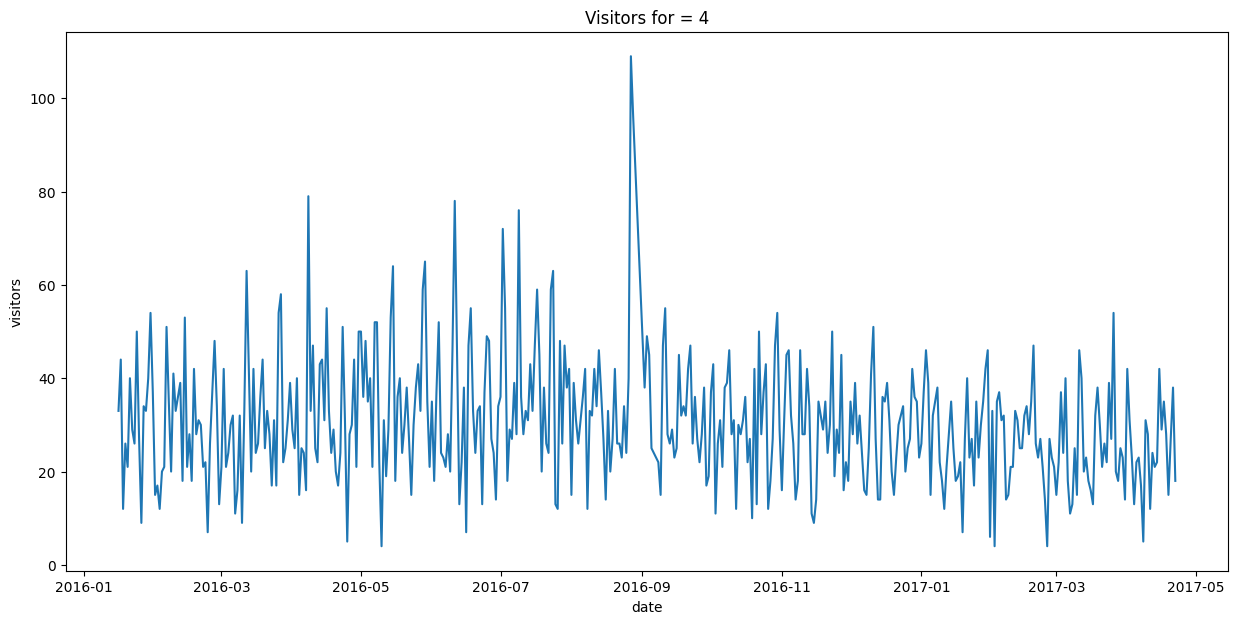

In [38]:
store_id = common_ids[0]
plt.figure(figsize=(15,7))
plt.plot(train.loc[train['air_store_id'] == store_id, 'visit_date'], train.loc[train['air_store_id'] == store_id, 'visitors'])
plt.title("Visitors for = {}".format(store_id))
plt.xlabel("date")
plt.ylabel("visitors")
plt.show()

In [39]:
train_x = train.drop(['air_store_id', 'visit_date', 'visitors'], axis=1)
train_y = np.log1p(train['visitors'].values)
test_x = test.drop(['id', 'air_store_id', 'visit_date', 'visitors'], axis=1)
print(train_x.shape, train_y.shape, test_x.shape)

(18226, 16) (18226,) (2340, 16)


### Light Gradient Boosting Regression Model to predict the future visitors

In [40]:
%%time
# fitting the model
gbm0 = lgb.LGBMRegressor(
    objective='regression',
    num_leaves=60,
    learning_rate=0.01,
    n_estimators=10000,
    verbosity=100)

gbm0.fit(train_x, train_y, eval_metric='rmse')

[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.022879
[LightGBM] [Debug] init for col-wise cost 0.000150 seconds, init for row-wise cost 0.000927 seconds
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000650 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Debug] Using Dense Multi-Val Bin
[LightGBM] [Info] Total Bins 970
[LightGBM] [Info] Number of data points in the train set: 18226, number of used features: 16
[LightGBM] [Info] Start training from score 2.948060
[LightGBM] [Debug] Trained a tree with leaves = 60 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 60 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 60 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 60 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 60 and depth = 11
[LightGBM] [Debug] Trained a tree with leav

LGBMRegressor(learning_rate=0.01, n_estimators=10000, num_leaves=60,
              objective='regression', verbosity=100)

In [41]:
predict_y = gbm0.predict(test_x)
test['visitors'] = np.expm1(predict_y)
test.head()

,id,visitors,visit_date,air_store_id,dow,year,month,min_visitors,mean_visitors,median_visitors,max_visitors,count_observations,air_genre_name,air_area_name,latitude,longitude,reserve_datetime_diff_x,reserve_visitors_x,reserve_datetime_diff_y,reserve_visitors_y
0,85_2017-04-23,2.079496,2017-04-23,85,6,2017,4,2.0,2.000000,2.0,2.0,1.0,4,14,35.694004,139.753601,-1.0,-1.0,-1.0,-1.0
1,85_2017-04-24,25.212773,2017-04-24,85,0,2017,4,1.0,22.457144,19.0,47.0,35.0,4,14,35.694004,139.753601,-1.0,-1.0,-1.0,-1.0
2,85_2017-04-25,30.928450,2017-04-25,85,1,2017,4,1.0,24.350000,24.5,43.0,40.0,4,14,35.694004,139.753601,-1.0,-1.0,-1.0,-1.0
3,85_2017-04-26,28.810483,2017-04-26,85,2,2017,4,15.0,28.125000,28.0,52.0,40.0,4,14,35.694004,139.753601,-1.0,-1.0,-1.0,-1.0
4,85_2017-04-27,32.323384,2017-04-27,85,3,2017,4,15.0,29.868422,30.0,47.0,38.0,4,14,35.694004,139.753601,-1.0,-1.0,-1.0,-1.0


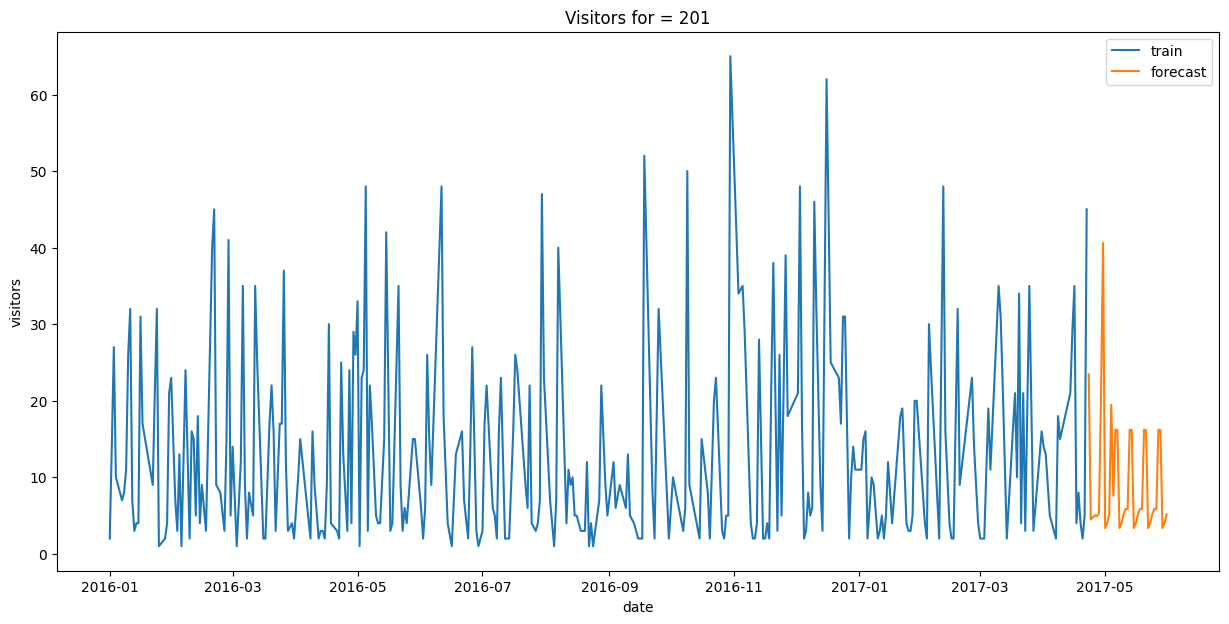

In [42]:
store_id = common_ids[41]
plt.figure(figsize=(15,7))
plt.plot(train.loc[train['air_store_id'] == store_id, 'visit_date'], train.loc[train['air_store_id'] == store_id, 'visitors'], label='train')
plt.plot(test.loc[test['air_store_id'] == store_id, 'visit_date'], test.loc[test['air_store_id'] == store_id, 'visitors'], label='forecast')
plt.title("Visitors for = {}".format(store_id))
plt.xlabel("date")
plt.ylabel("visitors")
plt.legend()
plt.show()


In [43]:
test['is_low']=np.where(test.visitors<test.max_visitors*0.1, True, False)
test.head()

,id,visitors,visit_date,air_store_id,dow,year,month,min_visitors,mean_visitors,median_visitors,...,count_observations,air_genre_name,air_area_name,latitude,longitude,reserve_datetime_diff_x,reserve_visitors_x,reserve_datetime_diff_y,reserve_visitors_y,is_low
0,85_2017-04-23,2.079496,2017-04-23,85,6,2017,4,2.0,2.000000,2.0,...,1.0,4,14,35.694004,139.753601,-1.0,-1.0,-1.0,-1.0,False
1,85_2017-04-24,25.212773,2017-04-24,85,0,2017,4,1.0,22.457144,19.0,...,35.0,4,14,35.694004,139.753601,-1.0,-1.0,-1.0,-1.0,False
2,85_2017-04-25,30.928450,2017-04-25,85,1,2017,4,1.0,24.350000,24.5,...,40.0,4,14,35.694004,139.753601,-1.0,-1.0,-1.0,-1.0,False
3,85_2017-04-26,28.810483,2017-04-26,85,2,2017,4,15.0,28.125000,28.0,...,40.0,4,14,35.694004,139.753601,-1.0,-1.0,-1.0,-1.0,False
4,85_2017-04-27,32.323384,2017-04-27,85,3,2017,4,15.0,29.868422,30.0,...,38.0,4,14,35.694004,139.753601,-1.0,-1.0,-1.0,-1.0,False


In [44]:
test.shape[0]

2340

In [45]:
test[(test.is_low==True)].shape[0]

121

In [46]:
print("For store = {}".format(store_id))
display(train.loc[train['air_store_id'] == store_id, ['visit_date', 'visitors']].tail(10))
print("Forecast for future dates")
display(test.loc[test['air_store_id'] == store_id, ['visit_date', 'visitors','is_low']].head(10))

For store = 201


,visit_date,visitors
14186,2017-04-09,15
14187,2017-04-14,21
14188,2017-04-15,29
14189,2017-04-16,35
14190,2017-04-17,4
14191,2017-04-18,8
14192,2017-04-19,4
14193,2017-04-20,2
14194,2017-04-21,5
14195,2017-04-22,45


Forecast for future dates


,visit_date,visitors,is_low
1053,2017-04-23,23.457203,False
1054,2017-04-24,4.488560,False
1055,2017-04-25,4.753568,False
1056,2017-04-26,5.037962,False
1057,2017-04-27,4.938115,False
1058,2017-04-28,5.267883,True
1059,2017-04-29,20.768362,False
1060,2017-04-30,40.627304,False
1061,2017-05-01,3.369684,True
1062,2017-05-02,3.987556,False


** Hence we got the predicted visitors' count for a particular cluster (MVP = 3) as well as overall group **

** Note the visitor/seat forecasting should be evaluated with only specific vendor/restaurants

** Use the MVP Predicted Visitor to reserve seats in the restaurant (in this case send alerts to them about the same) **

** When is_low == True, then send each vendor/restaurant some recommendations about special servies (special events/free coupons/speacial dishes) to improve the visitor frequency on less busier days**